In [0]:
#this is a data analysis for the recently uploaded corona virus in south korea, you can find the dataset here :

https://www.kaggle.com/kimjihoo/coronavirusdataset/kernels


In [0]:
#first i will import some basic libraries that we will use and upload the data from the kaggle dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import csv

In [0]:
#setting the paths to the csv files
path_patient = "patient.csv"
path_time = "time.csv"
path_route = "route.csv"

In [0]:
patient = pd.read_csv(path_patient, index_col="id")
time = pd.read_csv(path_time, index_col="date")
route = pd.read_csv(path_route, index_col="id")

In [6]:
patient.head()

,sex,birth_year,country,region,group,infection_reason,infection_order,infected_by,contact_number,confirmed_date,released_date,deceased_date,state
id,,,,,,,,,,,,,
1,female,1984.0,China,filtered at airport,NaN,visit to Wuhan,1.0,NaN,45.0,2020-01-20,2020-02-06,NaN,released
2,male,1964.0,Korea,filtered at airport,NaN,visit to Wuhan,1.0,NaN,75.0,2020-01-24,2020-02-05,NaN,released
3,male,1966.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,16.0,2020-01-26,2020-02-12,NaN,released
4,male,1964.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,95.0,2020-01-27,2020-02-09,NaN,released
5,male,1987.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,31.0,2020-01-30,2020-03-02,NaN,released


In [7]:
route.head()

,date,province,city,visit,latitude,longitude
id,,,,,,
1,2020-01-19,Incheon,Jung-gu,airport,37.460459,126.440680
1,2020-01-20,Incheon,Seo-gu,hospital_isolated,37.478832,126.668558
2,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.562143,126.801884
2,2020-01-23,Seoul,Jung-gu,hospital_isolated,37.567454,127.005627
3,2020-01-20,Incheon,Jung-gu,airport,37.460459,126.440680


In [8]:
time.head()

,acc_test,acc_negative,acc_confirmed,acc_released,acc_deceased,new_test,new_negative,new_confirmed,new_released,new_deceased
date,,,,,,,,,,
2020-01-20,1,0,1,0,0,1,0,1,0,0
2020-01-21,1,0,1,0,0,0,0,0,0,0
2020-01-22,4,3,1,0,0,3,3,0,0,0
2020-01-23,22,21,1,0,0,18,18,0,0,0
2020-01-24,27,25,2,0,0,5,4,1,0,0


# How about a map view?

In [11]:
#let's use the longitude and latitude data to get a view on the map, for this we will use the folium library 
import folium
cor_map = folium.Map(location=[36.5,128],
                       min_zoom=5,
                       max_zoom=10,
                       zoom_start=7,
                       tiles="cartodbpositron")
for lat, lon in zip(route["latitude"], route["longitude"]):
    folium.Circle([lat, lon],
                  color="purple",
                  radius=3).add_to(cor_map)
cor_map

This map, if continuously updated could give us an insight on areas that are safe, or have many others usages.


# How did we get here?

Let us find out the main reasons of infection within south korea (spoiler, most of them weren't within)

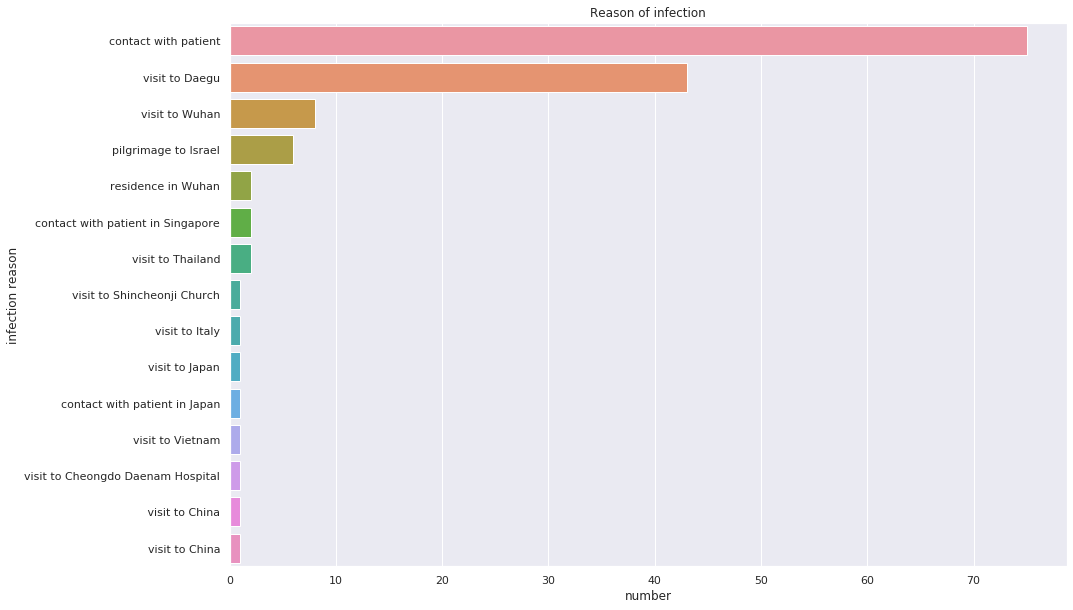

In [16]:
#The other most interesting thing to see is the reason for infection, for that we do as follows
infection = list(patient["infection_reason"].value_counts().index)

plt.figure(figsize=(15, 10))
sns.countplot(y = "infection_reason",
              data=patient,
              order=infection)
plt.title("Reason of infection")
plt.xlabel("number")
plt.ylabel("infection reason")
plt.show()

This gives us the main reason for the infection in SK being the contacts with patients (that mostly came from Wuhan), the main spreading area of the virus. Daegu seems to be the most affected area from the visits from wuhan, thus infecting further people.

In [0]:
#Let us now see the most affected people based on age and gender, first we need to add and age column
patient['birth_year'] = patient.birth_year.fillna(0.0).astype(int)
patient['birth_year'] = patient['birth_year'].map(lambda val: val if val > 0 else np.nan)
patient['age'] = 2020 - patient['birth_year'] 

In [0]:
patient.confirmed_date = pd.to_datetime(patient.confirmed_date)
date_cols = ["confirmed_date", "released_date", "deceased_date"]
for col in date_cols:
    patient[col] = pd.to_datetime(patient[col])

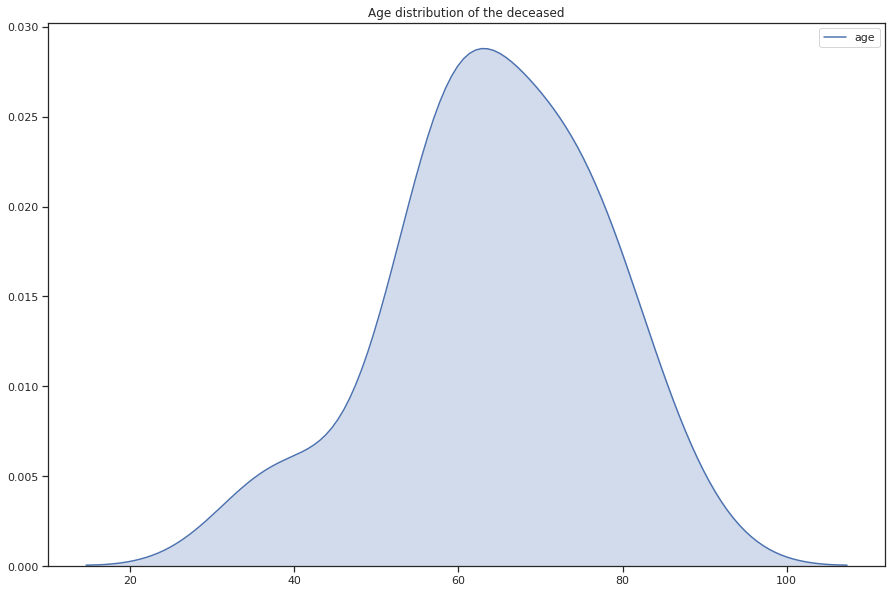

In [43]:
#First, we'll check the patients by age
deceased = patient[patient.state == 'deceased']
plt.figure(figsize=(15,10))
sns.set_style("ticks")
plt.title("Age distribution of the deceased")
sns.kdeplot(data=deceased['age'], shade=True)

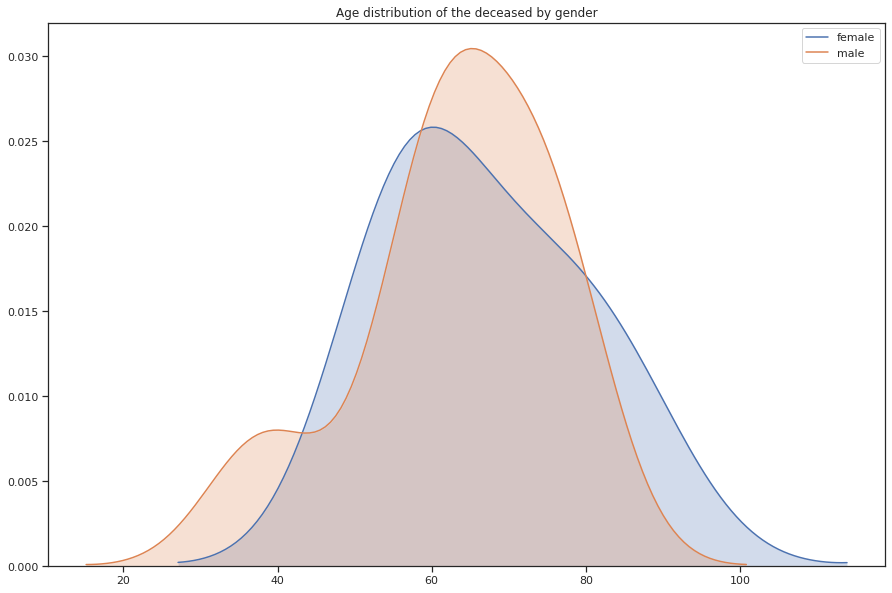

In [44]:
#now how about gender? 
male_deceased = deceased[deceased.sex=='male']
female_deceased = deceased[deceased.sex=='female']
plt.figure(figsize=(15,10))
sns.set_style("ticks")
plt.title("Age distribution of the deceased by gender")
sns.kdeplot(data=female_deceased['age'], label= 'female', shade=True)
sns.kdeplot(data=male_deceased['age'], label= 'male', shade=True)

In [0]:
# A little bit of necessary pre processing, forgive the messiness
import math
def group_age(age):
    """This function is used to group patients by age
    in steps of 10 years. It returns the age range
    of the patient as a string.
    """
    if age >= 0: # not NaN
        if age % 10 != 0:
            lower = int(math.floor(age / 10.0)) * 10
            upper = int(math.ceil(age / 10.0)) * 10 - 1
            return f"{lower}-{upper}"
        else:
            lower = int(age)
            upper = int(age + 9) 
            return f"{lower}-{upper}"
    return "Unknown"


patient["age_range"] = patient["age"].apply(group_age)

# duration of infection:
patient["time_to_release_since_confirmed"] = patient["released_date"] - patient["confirmed_date"]
patient["time_to_death_since_confirmed"] = patient["deceased_date"] - patient["confirmed_date"]
patient["duration_since_confirmed"] = patient[["time_to_release_since_confirmed", "time_to_death_since_confirmed"]].min(axis=1)
patient["duration_days"] = patient["duration_since_confirmed"].dt.days
age_ranges = sorted(set([ar for ar in patient["age_range"] if ar != "Unknown"]))
patient["state_by_gender"] = patient["state"] + "_" + patient["sex"]

# for mortality rate:
patient["state_deceased"] = (patient["state"] == "deceased").astype("int8")

In [0]:
#setting up age ranges to allow grading in the final plot
age_ranges = sorted(set([ar for ar in patient["age_range"] if ar != "Unknown"]))


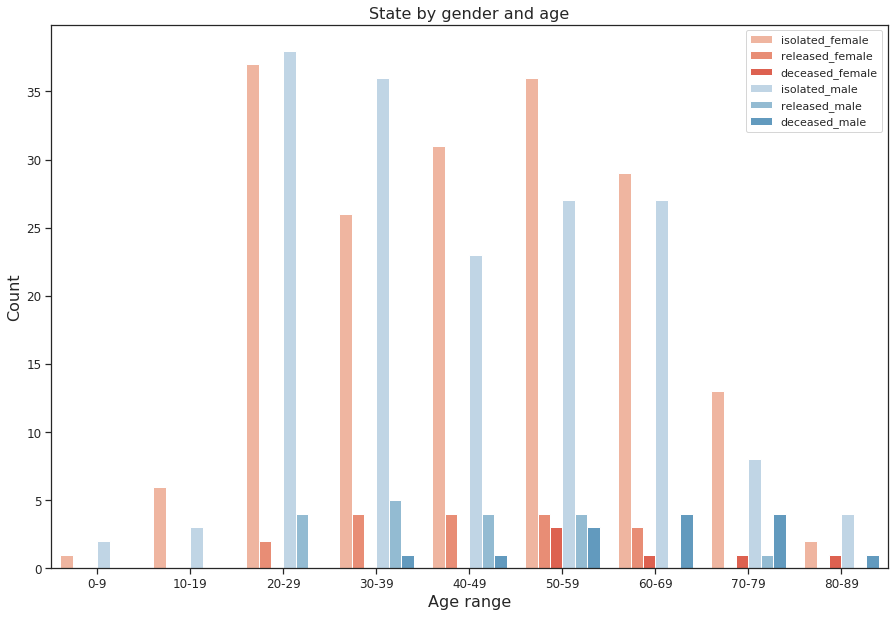

In [57]:
#finally, let's check the states of the infected, to see how serious the corona really is. 
age_gender_separate_labels =["isolated_female", "released_female", "deceased_female",
                       "isolated_male", "released_male", "deceased_male"]
custom_palette = sns.color_palette("Reds")[1:4] + sns.color_palette("Blues")[1:4]

plt.figure(figsize=(15, 10))
sns.countplot(x = "age_range",
              hue="state_by_gender",
              order=age_ranges,
              hue_order=age_gender_separate_labels,
              palette=custom_palette,
              data=patient)
plt.title("State by gender and age", fontsize=16)
plt.xlabel("Age range", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="upper right")
plt.show()

Most cases are either isolated or released after having recovered, putting death at a low value, meaning that corona virus, when approached appropriately within a country, can be handled to be less dangerous than the media advertises.